# Autoencoder

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

## Initialization

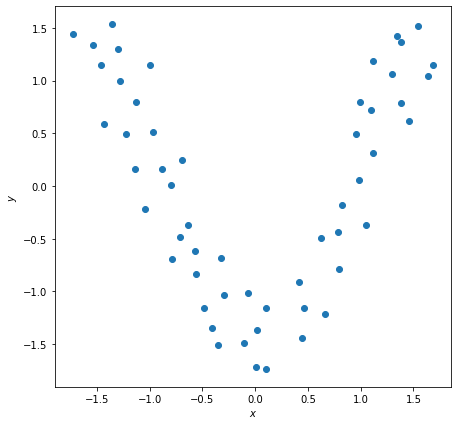

In [2]:
data = pickle.load(open('dataV.pickle', 'rb'))

plt.figure(figsize=(9, 7))
plt.scatter(data[:, 0], data[:, 1], label='Data')
plt.axis('scaled')
plt.xlabel('$x$')
plt.ylabel('$y$');

In [0]:
# Required for the contour lines
X, Y = np.mgrid[-2:2:100j, -2:2:100j]
data_grid = np.asarray([X.ravel(), Y.ravel()]).transpose()

# Reproducible results with TensorFlow
def reset():
    tf.reset_default_graph()
    tf.set_random_seed(1337)
    np.random.seed(1337)

## Part 1: Linear autoencoder

In [4]:
# Reset the graph before each run to get reproducible results
reset()

# Dimensions of our network
n_inputs = 2
n_hidden = 1
n_outputs = n_inputs  # In case of autoencoders (AEs), the output dimension must be the same as the input dimension

# This creates a node in the graph which can later be fed with an input
# [batch, input]: the batch dimension is set implicitly and specified later in the execution phase
input = tf.placeholder(tf.float64, shape=[None, n_inputs])

# The bottleneck layer contains the PCA codings (projections)
coding = tf.layers.dense(input, units=n_hidden)  # Creates a normal neural network layer

# The output layer produces (ideally) the input again
outputs = tf.layers.dense(coding, units=n_outputs)

# The MSE is our error function
loss = tf.reduce_mean(tf.square(outputs - input))

# Define the optimizer to use (Adam is a more advanced optimizer than SGD)
optimizer = tf.train.AdamOptimizer(learning_rate=0.05)

# Tells the optimizer that we want to minimize our error function
# It returns an operation node which we must later execute to apply one step of the optimizer
train = optimizer.minimize(loss)

# We have now completed our construction phase and are about to enter the execution phase. The latter is defined by a
# session object. You allways need a session to actually perform operations. The state of every variable is connected to
# the current session. The lifetime of the variables end when the session closes, e.g. after the with block in the following
# (which automatically closes the session)
with tf.Session() as sess:
    # This is the first time the variables get actually initialized
    tf.global_variables_initializer().run()

    # Repeat our training operation for multiple epochs
    epochs = 5000
    for epoch in range(epochs):
        # With the feed_dict argument, you must specify the values for all the defined placeholders in the graph (in this
        # case, we have only one - the input)
        train.run(feed_dict={input: data})
    
    # After the training finished, we can extract information from our network nodes
    proj_linear, predictions_linear, error_linear = sess.run([coding, outputs, loss], feed_dict={input: data})
    proj_grid_linear = coding.eval(feed_dict={input: data_grid}).reshape(X.shape)
    
    # Note: whenever it is possible, use sess.run() instead of node.eval(). With the former, you can compute the values for
    #       multiple nodes at once. This facilitates the re-use of already computed nodes (otherwise, the values of all
    #       dependent nodes are re-calculated)

error_linear

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


0.4888178025940389

In [0]:
pca = PCA(n_components=1)
projections = pca.fit_transform(data)
first_coeff = pca.components_

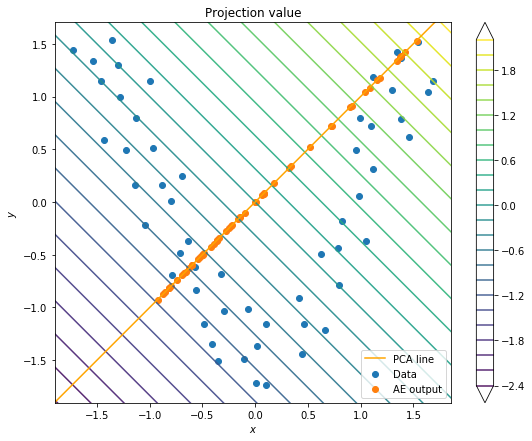

In [6]:
plt.figure(figsize=(9, 7))
plt.scatter(data[:, 0], data[:, 1], label='Data')
plt.axis('scaled')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = 0 +  (first_coeff[0][0]/first_coeff[0][1])* x_vals
plt.plot(x_vals, y_vals, color='orange', label='PCA line')
#old_c = pca.inverse_transform(projections)
plt.scatter(predictions_linear[:,0], predictions_linear[:,1], label='AE output')
#Z = pca.transform(data_grid)
#Z = Z.reshape(X.shape)
levels = np.arange(-2.4,2.4,0.2)
surf = axes.contour(X, Y, proj_grid_linear, cmap='viridis', alpha=0.9, levels=levels, extend='both')
plt.colorbar(surf)
plt.title('Projection value')
plt.legend()
plt.show()

## Part 2: Non-linear autoencoder

In [7]:
# Reset the graph before each run to get reproducible results
reset()

# Dimensions of our network
n_inputs = 2
n_hidden = 1
hidden_neurons = 20
n_outputs = n_inputs  # In case of autoencoders (AEs), the output dimension must be the same as the input dimension

#encoder
input = tf.placeholder(tf.float64, shape=[None, n_inputs])
en_hidden = tf.layers.dense(input, units=hidden_neurons, activation=tf.tanh)

#coding
coding = tf.layers.dense(en_hidden, units=n_hidden)  # Creates a normal neural network layer

#decoder
de_hidden = tf.layers.dense(coding, units=hidden_neurons, activation=tf.tanh)
outputs = tf.layers.dense(de_hidden, units=n_outputs)

weights = tf.trainable_variables()
regularizer = tf.contrib.layers.apply_regularization(tf.contrib.layers.l1_regularizer(0.002), weights)
loss = tf.reduce_mean(tf.square(outputs - input)) + regularizer

optimizer = tf.train.AdamOptimizer(learning_rate=0.05)

train = optimizer.minimize(loss)

with tf.Session() as sess:
    # This is the first time the variables get actually initialized
    tf.global_variables_initializer().run()

    # Repeat our training operation for multiple epochs
    epochs = 5000
    for epoch in range(epochs):

        train.run(feed_dict={input: data})
    
    proj_nonlinear, predictions_nonlinear, error_nonlinear = sess.run([coding, outputs, loss], feed_dict={input: data})
    proj_grid_nonlinear = coding.eval(feed_dict={input: data_grid}).reshape(X.shape)

error_nonlinear


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



0.07094791022334672

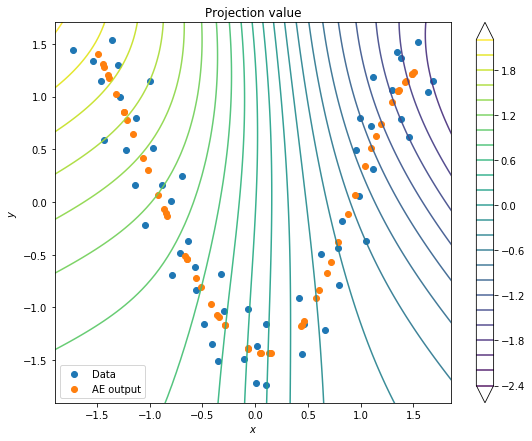

In [8]:
plt.figure(figsize=(9, 7))
plt.scatter(data[:, 0], data[:, 1], label='Data')
plt.axis('scaled')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
#old_c = pca.inverse_transform(projections)
plt.scatter(predictions_nonlinear[:,0], predictions_nonlinear[:,1], label='AE output')
#Z = pca.transform(data_grid)
#Z = Z.reshape(X.shape)
levels = np.arange(-2.4,2.4,0.2)
surf = axes.contour(X, Y, proj_grid_nonlinear, cmap='viridis', alpha=0.9, levels=levels, extend='both')
plt.colorbar(surf)
plt.title('Projection value')
plt.legend()
plt.show()

2.3) </br>
If we use non-linear activation function in the output layer, its output will be limited to a range (such as [-1, 1]) and thus we will not get the matched input

2.4) </br>
non-linear autoencoder fits the non linear data better with even distribution, no cluttering </br>
whereas in linear encoder, since we have 1D projections, most of the data projections happen to overlap. Thus we have peaks in few places.
